<a href="https://colab.research.google.com/github/trista-paul/DS-Unit-2-Sprint-3-Advanced-Regression/blob/master/Survival_Analysis_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Lecture summary
#Probability density function

#Example: Hazard function
#"instantaneous likelihood of failure" ex.lifetime mortality U curve

#Cumulative Distribution Function
#CDF is the integral of the PDF
#it is the area under the curve of sigmoid
#y P event less than or equal to x

#example: Survival function
#Survival analysis is applied to retention; also known as time to event
#birth, death are general terms for the interval
#birth: person issued welfare
#death: person improoves income and is no longer eligible
#survival answers how long the interval they are on welfare
#'data censorship' occurs when subject doesn't trigger death event
#or literally dies
#logistic reg doesn't have a way to interpret censorship, and survival barely does
#defaulting end of period as death or dropping are both bad

# Assignment - Customer Churn

Treselle Systems, a data consulting service, [analyzed customer churn data using logistic regression](http://www.treselle.com/blog/customer-churn-logistic-regression-with-r/). For simply modeling whether or not a customer left this can work, but if we want to model the actual tenure of a customer, survival analysis is more appropriate.

The "tenure" feature represents the duration that a given customer has been with them, and "churn" represents whether or not that customer left (i.e. the "event", from a survival analysis perspective). So, any situation where churn is "no" means that a customer is still active, and so from a survival analysis perspective the observation is censored (we have their tenure up to now, but we don't know their *true* duration until event).

Your assignment is to [use their data](https://github.com/treselle-systems/customer_churn_analysis) to fit a survival model, and answer the following questions:

- What features best model customer churn?
- What would you characterize as the "warning signs" that a customer may discontinue service?
- What actions would you recommend to this business to try to improve their customer retention?

Please create at least *3* plots or visualizations to support your findings, and in general write your summary/results targeting an "interested layperson" (e.g. your hypothetical business manager) as your audience.

This means that, as is often the case in data science, there isn't a single objective right answer - your goal is to *support* your answer, whatever it is, with data and reasoning.

Good luck!

In [67]:
!pip install lifelines

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lifelines

In [84]:
# Loading the data to get you started
df = pd.read_csv(
    'https://raw.githubusercontent.com/treselle-systems/'
    'customer_churn_analysis/master/WA_Fn-UseC_-Telco-Customer-Churn.csv')
pd.set_option('display.max_columns', None)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [0]:
#cell that does all cleaning operations at once
#process below
df = df.drop(columns = ['customerID'])
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

objects = df.select_dtypes(include=object)
notobjects = df.select_dtypes(exclude=object)

for label, col in objects.iteritems():
  print(col.value_counts())
  n = 0
  for types in col.unique():
      col = col.replace({types:n})
      n = n+1
  objects[label] = col
  print(objects[label].value_counts())
  
df = pd.concat([objects, notobjects], axis=1)
df = df.dropna() #the 11 totalcharges
df.head()

In [0]:
df.info()  # A lot of these are "object" - some may need to be fixed...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [0]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [0]:
#drop id and fix total charge's type
df = df.drop(columns = ['customerID'])
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
#make gender, is married, has dependents, has phone
#LOTS OF THINGS into a binary
#individually fix all objects that aren't yes or no, then loop

In [71]:
df['TotalCharges'].dtype

dtype('float64')

In [72]:
df['TotalCharges'].isnull().sum() #double checking because it refused to convert using astype

11

In [86]:
objects = df.select_dtypes(include=object)
objects.head(5)

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No
1,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No
2,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes
3,Male,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No
4,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes


In [87]:
#I wanted to try entirely cleaning the objects in one cell
for label, col in objects.iteritems():
  print(col.value_counts())
  n = 0
  for types in col.unique():
      col = col.replace({types:n})
      n = n+1
  objects[label] = col
  print(objects[label].value_counts())

Male      3555
Female    3488
Name: gender, dtype: int64
1    3555
0    3488
Name: gender, dtype: int64
No     3641
Yes    3402
Name: Partner, dtype: int64
1    3641
0    3402
Name: Partner, dtype: int64
No     4933
Yes    2110
Name: Dependents, dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


0    4933
1    2110
Name: Dependents, dtype: int64
Yes    6361
No      682
Name: PhoneService, dtype: int64
1    6361
0     682
Name: PhoneService, dtype: int64
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64
1    3390
2    2971
0     682
Name: MultipleLines, dtype: int64
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64
1    3096
0    2421
2    1526
Name: InternetService, dtype: int64
No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64
0    3498
1    2019
2    1526
Name: OnlineSecurity, dtype: int64
No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64
1    3088
0    2429
2    1526
Name: OnlineBackup, dtype: int64
No                     3095
Yes                    2422
No internet service    1526
Name: DeviceProtection, dtype: int64
0    3095
1    2422

In [88]:
objects.head() #perfect

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,1,0,1,1,1,0,0,0,1,1,1,0
2,1,1,0,1,1,0,1,0,0,0,0,0,0,0,1,1
3,1,1,0,0,0,0,1,1,1,1,0,0,1,1,2,0
4,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0,1


In [89]:
notobjects = df.select_dtypes(exclude=object)
notobjects.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,0,1,29.85,29.85
1,0,34,56.95,1889.50
2,0,2,53.85,108.15
3,0,45,42.30,1840.75
4,0,2,70.70,151.65


In [90]:
df = pd.concat([objects, notobjects], axis=1)
df = df.dropna() #the 11 totalcharges
df.head()

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,29.85,29.85
1,1,1,0,1,1,0,1,1,1,0,0,0,1,1,1,0,0,34,56.95,1889.50
2,1,1,0,1,1,0,1,0,0,0,0,0,0,0,1,1,0,2,53.85,108.15
3,1,1,0,0,0,0,1,1,1,1,0,0,1,1,2,0,0,45,42.30,1840.75
4,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0,1,0,2,70.70,151.65


In [92]:
df.describe()

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.504693,0.517491,0.298493,0.903299,1.325228,0.872582,0.718857,0.871303,0.776166,0.722412,0.816695,0.820677,0.688567,0.407281,1.315557,0.265785,0.162400,32.421786,64.798208,2283.300441
std,0.500014,0.499729,0.457629,0.295571,0.642585,0.737271,0.796556,0.737917,0.778542,0.795571,0.762952,0.761287,0.832934,0.491363,1.149523,0.441782,0.368844,24.545260,30.085974,2266.771362
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,18.250000,18.800000
25%,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,35.587500,401.450000
50%,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,29.000000,70.350000,1397.475000
75%,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000,55.000000,89.862500,3794.737500
max,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,3.000000,1.000000,1.000000,72.000000,118.750000,8684.800000


In [108]:
cph = lifelines.CoxPHFitter()
cph.fit(df, 'tenure', event_col='Churn')
cph.print_summary()
#something is happening with onlinebackup, partner and phoneservice.
#their likelihood to cancel increases in response to small changes in unit
#probably irrelevant (likelihood change is or near 1 w low coefs):
#totalcharges, gender, senior, monthlycharges

#low P club! (under 0.05)
#let's start improving the model by reducing features to these
#Partner, PhoneService, MultipleLines, OnlineSecurity, OnlineBackup,
#TechSupport, Contract
#PaperlessBilling, PaymentMethod, MonthlyCharges
#TotalCharges just seems to act unusual

<lifelines.CoxPHFitter: fitted with 7032 observations, 5163 censored>
      duration col = 'tenure'
         event col = 'Churn'
number of subjects = 7032
  number of events = 1869
    log-likelihood = -12684.29
  time fit was run = 2019-02-27 00:45:03 UTC

---
                  coef  exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
gender           -0.03       0.97      0.05  -0.72   0.47      1.09       -0.12        0.06
Partner           0.20       1.22      0.05   3.58 <0.005     11.50        0.09        0.30
Dependents       -0.07       0.93      0.07  -1.06   0.29      1.79       -0.21        0.06
PhoneService      0.26       1.29      0.13   1.97   0.05      4.34        0.00        0.52
MultipleLines    -0.11       0.89      0.05  -2.15   0.03      4.99       -0.22       -0.01
InternetService   0.04       1.04      0.07   0.62   0.54      0.90       -0.09        0.18
OnlineSecurity   -0.39       0.68      0.06  -6.07 <0.005     29.51       -0.51       -0.26
On

In [113]:
LowPClub = ['tenure', 'Churn',
            'Partner', 'PhoneService', 'MultipleLines', 'OnlineSecurity',
            'OnlineBackup', 'TechSupport', 'Contract', 'PaperlessBilling',
            'PaymentMethod', 'MonthlyCharges']
dfnew = df[LowPClub]
dfnew.head(1)

,tenure,Churn,Partner,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
0,1,0,0,0,0,0,0,0,0,0,0,29.85


In [115]:
cph.fit(dfnew, 'tenure', event_col='Churn')
cph.print_summary()
#like I thought MonthlyCharges wasn't really that relevant
#but had inflated P significance

<lifelines.CoxPHFitter: fitted with 7032 observations, 5163 censored>
      duration col = 'tenure'
         event col = 'Churn'
number of subjects = 7032
  number of events = 1869
    log-likelihood = -13932.43
  time fit was run = 2019-02-27 01:12:38 UTC

---
                  coef  exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
Partner           0.56       1.75      0.05  11.16 <0.005     93.73        0.46        0.66
PhoneService      0.90       2.47      0.12   7.70 <0.005     46.05        0.67        1.13
MultipleLines    -0.42       0.65      0.06  -7.70 <0.005     46.01       -0.53       -0.32
OnlineSecurity   -0.60       0.55      0.06 -10.68 <0.005     86.02       -0.71       -0.49
OnlineBackup      0.70       2.02      0.05  13.08 <0.005    127.48        0.60        0.81
TechSupport      -0.41       0.67      0.05  -7.54 <0.005     44.25       -0.51       -0.30
Contract         -1.70       0.18      0.06 -26.16 <0.005    498.80       -1.82       -1.57
Pa

In [116]:
dfnew = dfnew.drop(columns=['MonthlyCharges'])

cph.fit(dfnew, 'tenure', event_col='Churn')
cph.print_summary()
#The exp(coef) of these features is closer to reality now
#PhoneService, OnlineBackup and Partner are largest changes

<lifelines.CoxPHFitter: fitted with 7032 observations, 5163 censored>
      duration col = 'tenure'
         event col = 'Churn'
number of subjects = 7032
  number of events = 1869
    log-likelihood = -13933.34
  time fit was run = 2019-02-27 01:14:43 UTC

---
                  coef  exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
Partner           0.57       1.76      0.05  11.28 <0.005     95.67        0.47        0.66
PhoneService      0.86       2.36      0.11   7.62 <0.005     45.21        0.64        1.08
MultipleLines    -0.45       0.64      0.05  -8.79 <0.005     59.16       -0.55       -0.35
OnlineSecurity   -0.58       0.56      0.05 -10.74 <0.005     86.94       -0.68       -0.47
OnlineBackup      0.73       2.07      0.05  14.37 <0.005    153.04        0.63        0.83
TechSupport      -0.40       0.67      0.05  -7.46 <0.005     43.38       -0.50       -0.29
Contract         -1.70       0.18      0.06 -26.24 <0.005    501.61       -1.83       -1.57
Pa

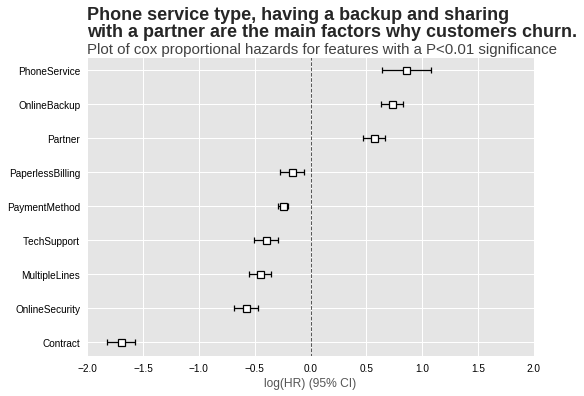

In [124]:
ax = cph.plot();
plt.xlim(-2, 2)
ax.tick_params(axis='both', labelcolor='black')
ax.text(x = -2, y=9.5, s='Phone service type, having a backup and sharing',
        fontsize=18, fontweight='bold');
ax.text(x = -2, y=9, s='with a partner are the main factors why customers churn.',
        fontsize=18, fontweight='bold');
ax.text(x = -2, y=8.5, s='Plot of cox proportional hazards for features with a P<0.01 significance',
        fontsize=15, color='#424242');
#the confidence interval of feature coefficient

In [95]:
!pip install -U matplotlib

Requirement already up-to-date: matplotlib in /usr/local/lib/python3.6/dist-packages (3.0.2)


In [127]:
time = dfnew.tenure.values
event = dfnew.Churn.values

kmf = lifelines.KaplanMeierFitter()

kmf.fit(time, event_observed=event)

<lifelines.KaplanMeierFitter: fitted with 7032 observations, 5163 censored>

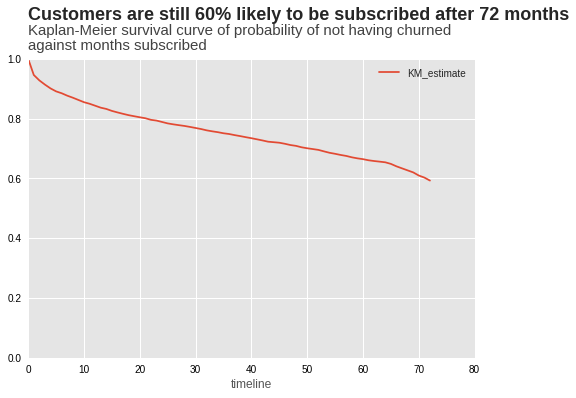

In [128]:
plt.style.use('ggplot')
ax = kmf.survival_function_.plot()
plt.ylim(0.00, 1.00)
plt.xlim(0, 80)
ax.tick_params(axis='both', labelcolor='black')
ax.text(x = 0, y=1.13, s='Customers are still 60% likely to be subscribed after 72 months',
        fontsize=18, fontweight='bold');
ax.text(x = 0, y=1.08, s='Kaplan-Meier survival curve of probability of not having churned',
        fontsize=15, color='#424242');
ax.text(x = 0, y=1.03, s='against months subscribed',
        fontsize=15, color='#424242');